In [20]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

# Data generation


Pour cet exemple, nous utiliserons deux classes de données comprises dans un cercle.
La fonction _make_circular_data permet de générer des données au sein d'un cercle.
make_double_cake_data permet de générer l'ensemble des points. L'argument num_sectors permet une division égale du cercle en num_sectors parties.

In [21]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

In [22]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax

Affichons les données :

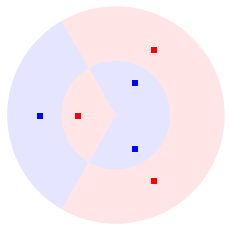

In [23]:
import matplotlib.pyplot as plt

num_sectors = 3
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

Définition du noyau

In [24]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

    # qml.broadcast pplique plusieurs fois unitaire à un motif spécifique de fils.
    # pattern="ring"applique un unitaire à deux fils à tous
    # M paires de fils voisines, où le dernier fil est considéré comme voisin du premie

Pour construire l'ansatz, cette couche est répétée plusieurs fois, en réutilisant le point de données $x$ mais en alimentant différents paramètres variationnels params dans chacun d'eux. Ensemble, le point de données et les paramètres variationnels déterminent entièrement l'ansatz d'intégration $U(x)$. Afin de construire le circuit du noyau complet, nous avons également besoin de son adjoint $U(x)^\dagger$, que nous pouvons obtenir via qml.adjoint.

In [25]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

In [26]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

In [27]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires) #Probabilité de chaque état

In [28]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [29]:
init_params = random_params(num_wires=5, num_layers=6)

In [30]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.093


In [31]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.093 0.012 0.721 0.149 0.055]
 [0.093 1.    0.056 0.218 0.73  0.213]
 [0.012 0.056 1.    0.032 0.191 0.648]
 [0.721 0.218 0.032 1.    0.391 0.226]
 [0.149 0.73  0.191 0.391 1.    0.509]
 [0.055 0.213 0.648 0.226 0.509 1.   ]]


# Prédictions

Pour effectuer une prédiction réelle, nous utiliserons le classificateur de vecteurs de support (SVC) de scikit-learn.



In [32]:
from sklearn.svm import SVC

In [33]:
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

In [34]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.833


In [35]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

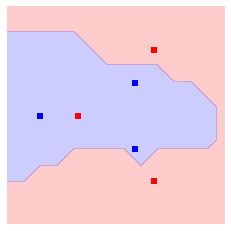

In [36]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())


# Training of the quantum kernel

Quantum feature maps can have variational parameters. In
this section, we discuss how to adjust these parameters to improve the classification capabilities of quantum embedding
kernels.




We first evaluate the kernel target alignment by PennyLane’s kernels module :

In [38]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

Now let’s code up an optimization loop and improve the kernel-target alignment :

We will make use of **regular gradient descent optimization**.  

In [39]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 50 - Alignment = 0.098
Step 100 - Alignment = 0.121
Step 150 - Alignment = 0.141
Step 200 - Alignment = 0.173
Step 250 - Alignment = 0.196
Step 300 - Alignment = 0.224
Step 350 - Alignment = 0.245
Step 400 - Alignment = 0.261
Step 450 - Alignment = 0.276
Step 500 - Alignment = 0.289


We want to assess the impact of training the parameters of the quantum kernel. Thus, let’s build a second support vector classifier with the trained kernel :

In [40]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

In [41]:
accuracy_trained = accuracy(svm_trained, X, Y)

Following on the results that SVM’s have proven good generalisation behavior, it will be interesting to inspect the decision boundaries of our classifier:

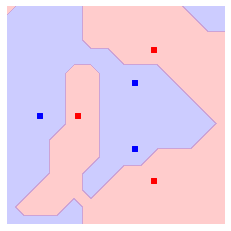

In [42]:
trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())